In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from multiprocessing import Pool, shared_memory
from scipy.stats import erlang, norm
from scipy.special import erf
import math

In [2]:
def create_Erlang_dist(lamb, k):
    def Erlang_dist(x):
        return erlang.pdf(x, k, scale=1/lamb)
    return Erlang_dist

def create_Erlang_cdf(lamb, k):
    def Erlang_cdf(x):
        return erlang.cdf(x, k, scale=1/lamb)
    return Erlang_cdf

def q1(r, mu, sigma):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp 
    return (mu/2)*erf((r-mu)/sqrt(2*sigma*sigma)) - (sigma/sqrt(2*pi))*exp(-(r-mu)**2/(2*sigma*sigma))

def q2(r, mu, sigma, c):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp    
    return ( .5*(1-(mu/c))*erf((r-mu)/sqrt(2*sigma*sigma))
            + (sigma/sqrt(2*pi*c*c))*exp(-(r-mu)**2/(2*sigma*sigma)))
def g(r, c):
    arcsin = np.arcsin
    pi = np.pi
    power = np.power
    return (.5 
            + (2*r/(3*c*pi)) 
            - (r/(c*pi))*power(1- (c/r)**2, 1/2)
            + (r/(3*c*pi))*power(1- (c/r)**2, 3/2)
            - (arcsin(c/r)/pi))


def k(r,c):
    pi = np.pi
    arcsin = np.arcsin
    power=np.power
    return ((pi*r/4) 
            - (c/2)*power(1- (c/r)**2, 1/2)
            - (r/2)*arcsin(c/r)
               )    

def K(r,c):
    pi = np.pi
    arcsin = np.arcsin
    power=np.power
    return ((pi*r*c/4) 
            - (1/6)*power(1- (c/r)**2, 1/2)*(2*(r**2) + c**2)
            - (r*c/2)*arcsin(c/r)
               )    

def alpha_exp(n ,lamb, c):
    return ((erlang.pdf(c, n, scale=1/lamb)/lamb) 
           + (1-(n/(c*lamb)))*erlang.cdf(c, n, scale=1/lamb))

def alpha_clt(n, mu, sigma, c):
    return (q2(c,n*mu, np.sqrt(n)*sigma, c) - q2(-c,n*mu, np.sqrt(n)*sigma, c))

def gamma_exp(n ,lamb, c, warning=False, clt=False):
    dist_func = create_Erlang_dist(lamb, n)
    in1, err1 = integrate.quad(lambda r: r*dist_func(r),
                          0, 
                          c, epsabs=0,limit=1000)
    in2, err2 = integrate.quad(lambda r: g(r, c)*dist_func(r),
                                              c, 
                                              np.inf, epsabs=0, limit=1000)
    if  (err1 == 0 or err2 == 0) and warning:
        print(f"Warning in gamma_exp err1:{err1}, err2:{err2}")
        
    if (err1 == 0 or err2 == 0) and clt and (n/lamb) >= c:
        in2 = in2 = g(n/lamb, c)
        
    return (2/(3*c*np.pi))*in1 + in2


def gamma_clt(n, mu, sigma, c):
    sqrt = np.sqrt
    pi = np.pi
    f1 = (2/(3*pi*c))*(q1(c, n*mu, sqrt(n)*sigma)-q1(-c, n*mu, sqrt(n)*sigma))
    if c > n*mu:
        f2 = (2/(3*pi))*(2-erf((c-n*mu)/sqrt(2*n*sigma*sigma))-erf((c+n*mu)/sqrt(2*n*sigma*sigma)))
    else:
        f2 = g(n*mu, c)
    return f1+f2

# Test off-diagonals that sampled from exponential distribution

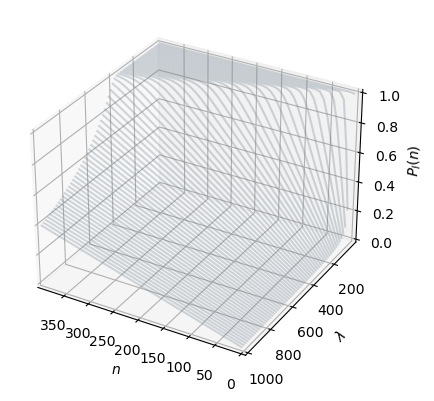

In [929]:
c=1
ns = 4*np.arange(1, 100, 2).astype(np.int32)#np.array([4, 8, 16, 32, 64, 128, 256])#, 512, 1024])
lambs = np.linspace(1, 1000, 60)# np.array([1, 10, 50, 100, 500])

alphas = np.array([[alpha_exp(n ,lamb, c) 
                             for n in ns]
                             for lamb in lambs ])


ax = plt.figure().add_subplot(projection='3d', azim=120)

for k,lamb in enumerate(lambs):
    ax.plot(ns, 1-alphas[k,:], zs=lamb, zdir='y',
            color='slategray'#'royalblue'
            , alpha=.3)


ax.set(xlim=(0, ns[-1]), ylim=(lambs[0], lambs[-1]), zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\lambda$', zlabel=r'$P_I(n)$')    
plt.show()

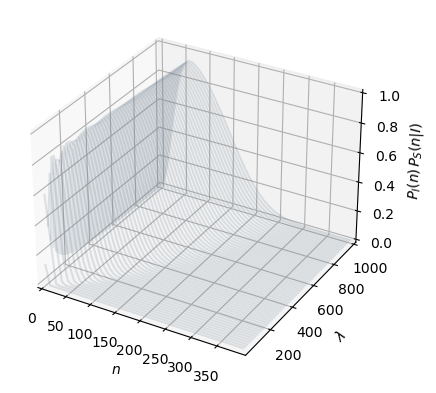

In [930]:
c=1
ns = 4*np.arange(1, 100, 2).astype(np.int32)#np.array([4, 8, 16, 32, 64, 128, 256])#, 512, 1024])
lambs = np.linspace(1, 1000, 60)# np.array([1, 10, 50, 100, 500])

alphas = np.array([[alpha_exp(n ,lamb, c) 
                             for n in ns]
                             for lamb in lambs ])
gammas = np.array([[gamma_exp(n ,lamb, c, clt=True) 
                             for n in ns]
                             for lamb in lambs ]) 

ax = plt.figure().add_subplot(projection='3d')

for k,lamb in enumerate(lambs):
    ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=lamb, zdir='y',
            color='slategray'#'royalblue'
            , alpha=.2)
       

ax.set(xlim=(0, ns[-1]), ylim=(lambs[0], lambs[-1]), zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\lambda$', zlabel=r'$P_I(n) \, P_S(n | I)$')    
plt.show()

# The effect of increasing c, or the upper bound for degradation rate:
## It acts like a scaling factor that zooms in.

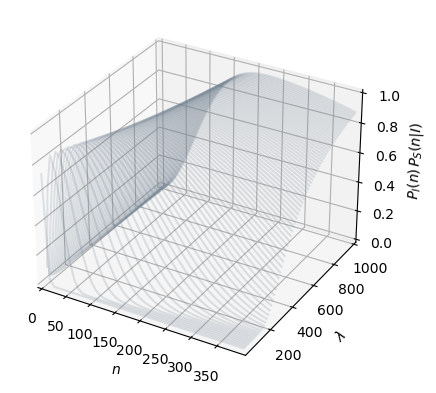

In [743]:
c=10
ns = 4*np.arange(1, 100, 2).astype(np.int32)#np.array([4, 8, 16, 32, 64, 128, 256])#, 512, 1024])
lambs = np.linspace(1, 1000, 80)# np.array([1, 10, 50, 100, 500])

alphas = np.array([[alpha_exp(n ,lamb, c) 
                             for n in ns]
                             for lamb in lambs ])
gammas = np.array([[gamma_exp(n ,lamb, c, clt=True) 
                             for n in ns]
                             for lamb in lambs ]) 

ax = plt.figure().add_subplot(projection='3d')

for k,lamb in enumerate(lambs):
    ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=lamb, zdir='y',
            color='slategray'#'royalblue'
            , alpha=.2)  

ax.set(xlim=(0, ns[-1]), ylim=(lambs[0], lambs[-1]), zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\lambda$', zlabel=r'$P_I(n) \, P_S(n | I)$')    
plt.show()

# Test off-diagonals that modeled by CLT.

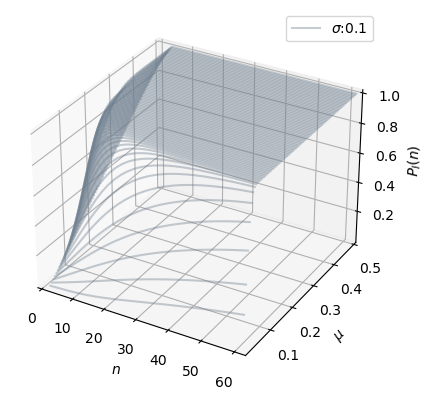

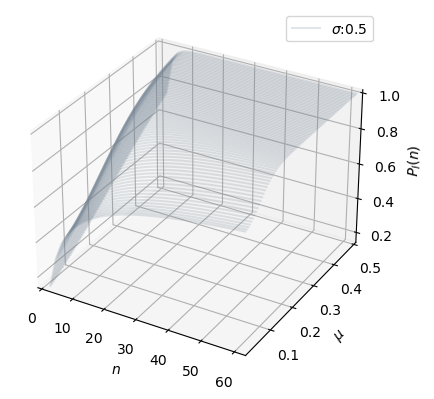

In [931]:
c=1
ns = np.arange(2, 64, 2).astype(np.int32)
sigmas = np.array([.1, .5])


colors = ['royalblue','slategray','navy']
opacity = [.4, .2]


for i,sigma in enumerate(sigmas):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')    
    mus = np.linspace(0.001, .5, 80)

    alphas = np.array([[alpha_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])
    

    for k,mu in enumerate(mus):
        
        ax.plot(ns, 1-alphas[k,:], zs=mu, zdir='y',
                color='slategray',#colors[i%3], 
                alpha=opacity[i%3], label= (r"$\sigma$:" f"{sigma}" if k == 0 else ""))

    ax.set(xlim=(0, ns[-1]), ylim=(mus[0], mus[-1]), #zlim=(0, 1),
           xlabel=r'$n$', ylabel=r'$\mu$', zlabel=r'$P_I(n)$')    
    ax.legend()
    plt.show()

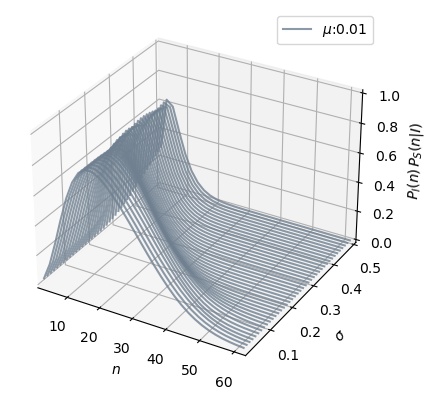

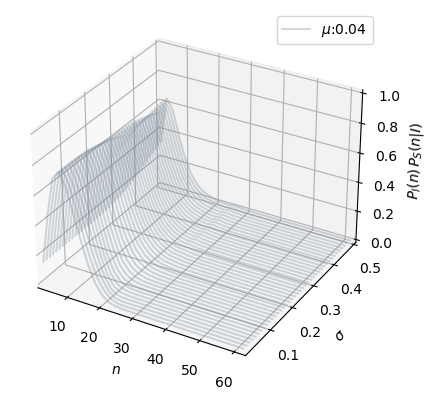

In [933]:
c=1
ns = np.arange(2, 64,2).astype(np.int32)
mus = np.array([.01, .04])

opacity = [.8, .3]
colors = [ 'slategray','navy', 'royalblue']
for i,mu in enumerate(mus):
    ax = plt.figure().add_subplot(projection='3d', azim=-60)

    sigmas = np.linspace(0.001, .5, 40)

    alphas = np.array([[alpha_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for sigma in sigmas ])

    gammas = np.array([[gamma_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for sigma in sigmas])


    for k,sigma in enumerate(sigmas):
        
        ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=sigma, zdir='y',
                color='slategray',#colors[i%3], 
                alpha=opacity[i%2], label= (r"$\mu$:" f"{mu}" if k == 0 else ""))


    ax.set(xlim=(ns[0], ns[-1]), ylim=(sigmas[0], sigmas[-1]), zlim=(0, 1),
           xlabel=r'$n$', ylabel=r'$\sigma$', zlabel=r'$P_I(n) \, P_S(n | I)$')    
    plt.legend()
    plt.show()

In [3]:
from scipy.linalg import eigvals

In [750]:
n = 200
repeats = 100
gershgorin_stats = np.zeros((repeats, n))
egien_stats = np.zeros_like(gershgorin_stats)
for i in range(repeats):
    m = np.random.normal(0,1, (n,n))
    rows = np.sum(np.abs(m - np.diag(np.diag(m))), axis=1)
    gershgorin_stats[i, :] = rows
    es = eigvals(m)
    radii = np.array([np.sqrt(np.real(e)**2 + np.imag(e)**2) for e in es])
    egien_stats[i, :] = radii
    

In [4]:
def p(a, gamma ,n):    
    return (1 - gamma*(1-a))**n - a**n

def dpda(a, gamma, n):
    return n*gamma*(1 - gamma*(1-a))**(n-1) - n*a**(n-1)

def dpdgamma(a, gamma, n):
    return -n*(1-a)*(1 - gamma*(1-a))**(n-1)

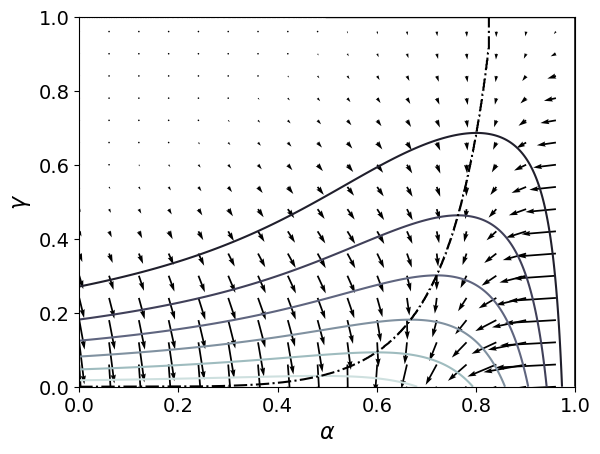

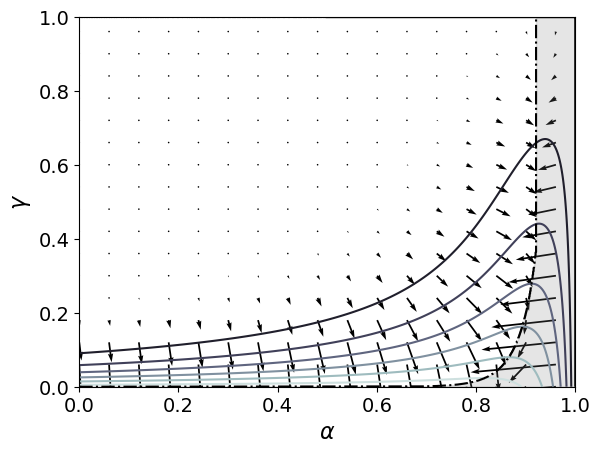

In [9]:
s = 20
alphas = np.linspace(0,1,50*s)
gammas = np.linspace(0,1,50*s)

Alphas, Gammas   = np.meshgrid(alphas,gammas,  indexing='ij')
n = 6

ps = p(Alphas,Gammas,  n)
i_dir = dpda(Alphas, Gammas, n)
j_dir = dpdgamma(Alphas, Gammas, n)

plt.contour(Alphas, Gammas, ps, cmap=plt.cm.bone)
plt.quiver(Alphas[::3*s,::3*s], Gammas[::3*s,::3*s], i_dir[::3*s,::3*s], j_dir[::3*s,::3*s])


a = np.array([ alphas[np.argmin(np.abs(i_dir[:,j]))] for j in range(gammas.shape[0])])
max_a = 0
for i in range(a.shape[0]):
    if a[i] > max_a:
        max_a = a[i]
    if a[i] == 0:
        a[i] = max_a
plt.plot(a, gammas, '-.', color='black')

#plt.fill_betweenx(gammas, 1, a, color='gray', alpha=.2)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel(r"$\gamma$", fontsize=16)
plt.xlabel(r"$\alpha$", fontsize=16)
plt.show()

n = 20

ps = p(Alphas,Gammas,  n)
i_dir = dpda(Alphas, Gammas, n)
j_dir = dpdgamma(Alphas, Gammas, n)

plt.contour(Alphas, Gammas, ps, cmap=plt.cm.bone)
plt.quiver(Alphas[::3*s,::3*s], Gammas[::3*s,::3*s], i_dir[::3*s,::3*s], j_dir[::3*s,::3*s])


a = np.array([ alphas[np.argmin(np.abs(i_dir[:,j]))] for j in range(gammas.shape[0])])
max_a = 0
for i in range(a.shape[0]):
    if a[i] > max_a:
        max_a = a[i]
    if a[i] == 0:
        a[i] = max_a
plt.plot(a, gammas, '-.', color='black')
plt.fill_betweenx(gammas, 1, a, color='gray', alpha=.2)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel(r"$\gamma$", fontsize=16)
plt.xlabel(r"$\alpha$", fontsize=16)
plt.show()